<a href="https://colab.research.google.com/github/anmolkhurana490/Yoga-Posture-Recognition-and-Correction-System/blob/main/ai_yoga_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mediapipe

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import math
import random

In [ ]:
import mediapipe as mp
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

def extract_zip(dir_name):
  # Replace with the actual path to your zip file in Google Drive
  zip_file_path = f'/content/drive/MyDrive/AI yoga trainer/large_dataset/{dir_name}.zip'
  # Replace with the desired extraction location in Colab
  extract_path = f'/content/large_dataset/{dir_name}'
  try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)
    print(f"Successfully unzipped {zip_file_path} to {extract_path}")
  except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_file_path}")
  except Exception as e:
    print(f"An error occurred: {e}")

for dir_name in ['train', 'val', 'test']:
  extract_zip(dir_name)

Successfully unzipped /content/drive/MyDrive/AI yoga trainer/large_dataset/train.zip to /content/large_dataset/train
Successfully unzipped /content/drive/MyDrive/AI yoga trainer/large_dataset/val.zip to /content/large_dataset/val
Successfully unzipped /content/drive/MyDrive/AI yoga trainer/large_dataset/test.zip to /content/large_dataset/test


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
train_dir = '/content/large_dataset/train'
validation_dir = '/content/large_dataset/val'
test_dir = '/content/large_dataset/test'

In [ ]:
mpPose=mp.solutions.pose
mpDraw=mp.solutions.drawing_utils
pose=mpPose.Pose(min_detection_confidence=0.7)

In [ ]:
img=tf.io.read_file('/content/large_dataset/test/Akarna_Dhanurasana/Akarna_Dhanurasana_image_77.jpg')
img=tf.image.decode_jpeg(img, channels=3)
results=pose.process(img.numpy())

(-0.5, 558.5, 305.5, -0.5)

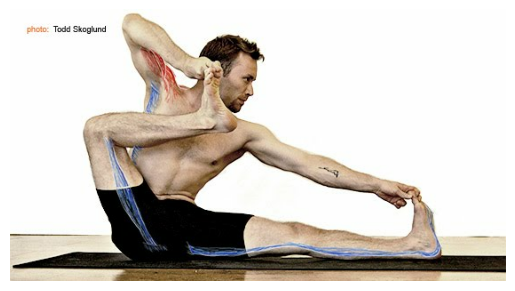

In [ ]:
plt.imshow(img.numpy())
plt.axis('off')

In [ ]:
# Rotate a point in 3D space by point (a,b,c)
def rotate_point(point, angles, arbitrary_point):
    """
    Rotate point (x,y,z) around pivot (a,b,c) by:
      - alpha around X-axis
      - beta  around Y-axis
      - gamma around Z-axis
    Angles in radians.
    Returns (x', y', z').
    """

    x, y, z = point
    a, b, c = arbitrary_point
    alpha, beta, gamma = angles

    ca, sa = math.cos(alpha), math.sin(alpha)
    cb, sb = math.cos(beta), math.sin(beta)
    cg, sg = math.cos(gamma), math.sin(gamma)

    x_prime = cg*(cb*(x - a) + sb*(sa*(y - b) + ca*(z - c))) - sg*(ca*(y - b) - sa*(z - c)) + a
    y_prime = sg*(cb*(x - a) + sb*(sa*(y - b) + ca*(z - c))) + cg*(ca*(y - b) - sa*(z - c)) + b
    z_prime = -sb*(x - a) + cb*(sa*(y - b) + ca*(z - c)) + c

    return x_prime, y_prime, z_prime

In [ ]:
def visualize_landmarks(image_path):
  mp_drawing = mp.solutions.drawing_utils
  mp_pose = mp.solutions.pose

  with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
      # Draw landmarks on the image
      annotated_image = image.copy()
      mp_drawing.draw_landmarks(
          annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

      # Display the annotated image using Matplotlib
      plt.figure(figsize=(8, 8))
      plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
      plt.title("Pose Landmarks")
      plt.axis('off')  # Hide axes
      plt.show()
    else:
      print("No pose landmarks detected in the image.")

In [ ]:
len(results.pose_landmarks.landmark)
# print(results.pose_landmarks.landmark)

33

(-0.5, 558.5, 305.5, -0.5)

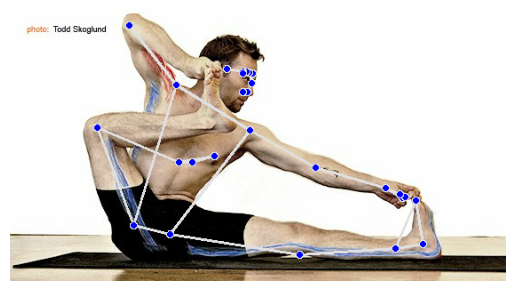

In [ ]:
annonated_image = img.numpy().copy()
mpDraw.draw_landmarks(annonated_image, results.pose_landmarks, mpPose.POSE_CONNECTIONS)
plt.imshow(annonated_image)
plt.axis('off')

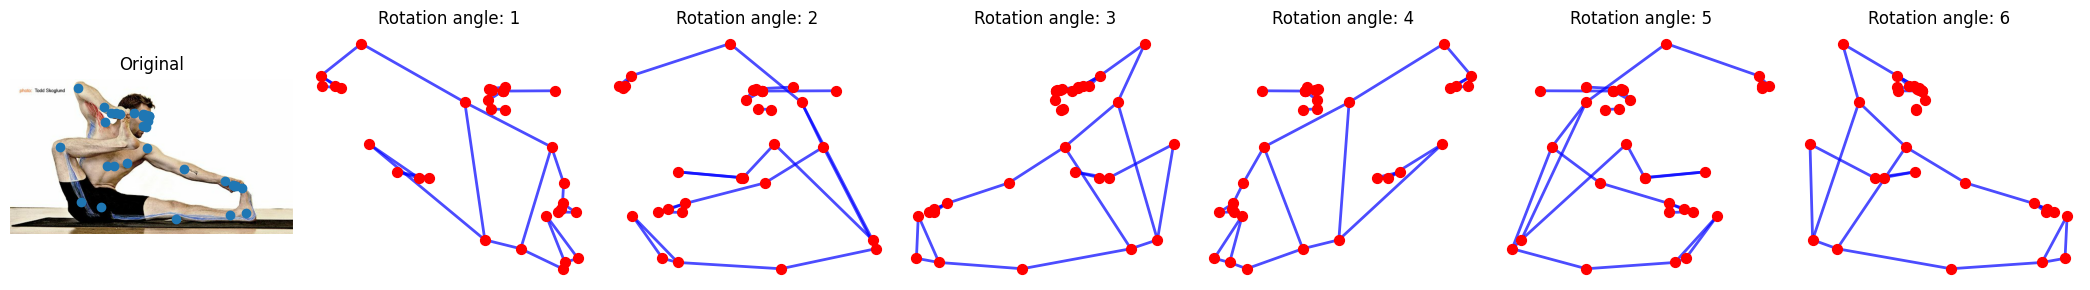

In [ ]:
fig, axes = plt.subplots(1, 7, figsize=(21, 3)) # 7 subplots in one row

original_img_np = img.numpy().copy()
axes[0].imshow(original_img_np)
axes[0].scatter([landmark.x*len(img[0]) for landmark in results.pose_landmarks.landmark], [landmark.y*len(img) for landmark in results.pose_landmarks.landmark])
axes[0].set_title("Original")
axes[0].axis('off')

angles_list = [1,2,3,4,5,6]

for i, angle in enumerate(angles_list):
  rotated_img_np = img.numpy().copy()
  angles = (0, angle, 0) # Assuming rotation around Y-axis for visualization

  rotated_landmarks = [rotate_point((landmark.x, landmark.y, landmark.z), angles, (0.5, 0.5, 0)) for landmark in results.pose_landmarks.landmark]

  x_coords = [point[0] for point in rotated_landmarks]
  y_coords = [point[1] for point in rotated_landmarks]
  z_coords = [point[2] for point in rotated_landmarks]

  connections = mpPose.POSE_CONNECTIONS
  for connection in connections:
    start_idx, end_idx = connection
    axes[i+1].plot([x_coords[start_idx], x_coords[end_idx]],
                [y_coords[start_idx], y_coords[end_idx]],
                'blue', linewidth=2, alpha=0.7)

  # Draw landmarks
  axes[i+1].scatter(x_coords, y_coords, c='red', s=50, zorder=5)

  # axes[i+1].imshow(rotated_img_np)
  axes[i+1].invert_yaxis()
  axes[i+1].set_title(f"Rotation angle: {angle}")
  axes[i+1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
classes = np.unique(os.listdir(validation_dir))
num_classes = len(classes)
print("Number of classes:", num_classes)

Number of classes: 82


In [ ]:
classes

In [ ]:
def count_images_in_directories(base_dir):
    counts = {}
    total = 0

    for class_name in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, class_name)
        if os.path.isdir(class_dir):
            image_count = len([name for name in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, name))])
            counts[class_name] = image_count
            total += image_count

    return counts, total

counts, total = count_images_in_directories(train_dir)
num_classes = len(counts)
class_weights = {label: total / (num_classes * count) for label, count in counts.items()}
print("Training set weights:", class_weights)
print("total images:", total)

Training set weights: {'Dolphin_Pose_or_Ardha_Pincha_Mayurasana_': 3.386178861788618, 'Scale_Pose_or_Tolasana_': 1.6161308203991132, 'Cockerel_Pose': 1.3544715447154472, 'Cow_Face_Pose_or_Gomukhasana_': 0.8220781051741153, 'Child_Pose_or_Balasana_': 0.6553894571203777, 'Locust_Pose_or_Salabhasana_': 0.9001234949058351, 'Supta_Virasana_Vajrasana': 0.6292898769695662, 'Sitting pose 1 (normal)': 0.4063414634146341, 'Low_Lunge_pose_or_Anjaneyasana_': 0.8833510074231177, 'Split pose': 0.7146709155533766, 'Standing_Split_pose_or_Urdhva_Prasarita_Eka_Padasana_': 1.545864262990456, 'Extended_Revolved_Triangle_Pose_or_Utthita_Trikonasana_': 0.6676972403526852, 'Scorpion_pose_or_vrischikasana': 0.8725123447553494, 'Warrior_II_Pose_or_Virabhadrasana_II_': 0.7646210333071073, 'Side-Reclining_Leg_Lift_pose_or_Anantasana_': 3.091728525980912, 'Supported_Shoulderstand_pose_or_Salamba_Sarvangasana_': 0.7368886642234298, 'Plow_Pose_or_Halasana_': 1.4081139821299202, 'Crane_(Crow)_Pose_or_Bakasana_': 2.

In [ ]:
print("Min count:", min(counts.values()), "Max weight:", max(class_weights.values()))
print("Max count:", max(counts.values()), "Min weight:", min(class_weights.values()))

Min count: 25 Max weight: 5.688780487804878
Max count: 350 Min weight: 0.4063414634146341


In [ ]:
label_lookup = tf.keras.layers.StringLookup(
    vocabulary = classes,
    mask_token = None,
    num_oov_indices = 0
)

In [ ]:
def apply_noise_augmentation(keypoints, noise_factor=0.02):
    """
    Add small random noise to keypoints
    """
    noise = np.random.normal(0, noise_factor, keypoints.shape)
    return keypoints + noise

def apply_scale_augmentation(keypoints, scale_range=(0.9, 1.1)):
    """
    Apply random scaling to keypoints
    """
    scale = random.uniform(scale_range[0], scale_range[1])
    center = np.mean(keypoints, axis=0)
    return center + (keypoints - center) * scale

def comprehensive_augmentation(keypoints, num_augmentations=5):
    """
    Apply comprehensive augmentation including rotation, noise, and scaling
    """
    augmented_keypoints = []

    # Original keypoints
    augmented_keypoints.append(keypoints)

    # # Calculate center point (hip center as pivot)
    # left_hip = keypoints[23]  # Left hip landmark
    # right_hip = keypoints[24]  # Right hip landmark
    # center_point = (left_hip + right_hip) / 2
    center_point = np.mean(keypoints, axis=0)

    for _ in range(num_augmentations):
        # Apply Rotation Augmentation
        # Angles are in radians.
        alpha = random.uniform(-0.5, 0.5) # approx -28 to 28 degrees
        beta = random.uniform(-1.5, 1.5) # approx -86 to 86 degrees
        gamma = random.uniform(-0.3, 0.3) # approx -17 to 17 degrees
        angles = (alpha, beta, gamma)

        rotated_keypoints = [rotate_point(point, angles, center_point) for point in keypoints]
        current_keypoints = np.array(rotated_keypoints)

        # Apply noise
        current_keypoints = apply_noise_augmentation(current_keypoints, noise_factor=0.015)

        # Apply scaling
        current_keypoints = apply_scale_augmentation(current_keypoints, scale_range=(0.95, 1.05))

        augmented_keypoints.append(current_keypoints)

    return augmented_keypoints

In [ ]:
angle_triplets = [
    (11, 13, 15),  # Left shoulder-elbow-wrist
    (12, 14, 16),  # Right shoulder-elbow-wrist
    (13, 15, 17),  # Left elbow-wrist-pinky
    (14, 16, 18),  # Right elbow-wrist-pinky
    (23, 11, 13),  # Left hip-shoulder-elbow
    (24, 12, 14),  # Right hip-shoulder-elbow
    (11, 23, 25),  # Left shoulder-hip-knee
    (12, 24, 26),  # Right shoulder-hip-knee
    (23, 25, 27),  # Left hip-knee-ankle
    (24, 26, 28),  # Right hip-knee-ankle
    (25, 27, 29),  # Left knee-ankle-heel
    (26, 28, 30),  # Right knee-ankle-heel
    (11, 0, 12),   # Left shoulder-nose-right shoulder
    (23, 0, 24),   # Left hip-nose-right hip
    (11, 24, 12),  # Left shoulder-right hip-right shoulder (torso angle)
    (12, 23, 11),  # Right shoulder-left hip-left shoulder (torso angle)
]

import numpy as np

def compute_angle(a, b, c):
    """
    Calculates the angle (in degrees) at point `b` formed by the line segments ab and cb.
    All points must be numpy arrays of shape (3,) for x, y, z.
    """
    ab = a - b
    cb = c - b
    cosine_angle = np.dot(ab, cb) / (np.linalg.norm(ab) * np.linalg.norm(cb) + 1e-8)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

def extract_joint_angles(keypoints):
    """
    keypoints: numpy array of shape (33, 3) with x, y, z
    returns: list of joint angles (in degrees) for selected joints
    """

    angles = []
    for a, b, c in angle_triplets:
        if max(a, b, c) >= len(keypoints):  # safety check
            angles.append(0.0)
            continue
        angle = compute_angle(np.array(keypoints[a]),
                              np.array(keypoints[b]),
                              np.array(keypoints[c]))
        angles.append(angle)

    return np.array(angles) / 180

In [ ]:
# no. of augmentations = augment_factor * class_weight

tf.data.experimental.enable_debug_mode()
def process_image_with_augmentation(image_path, augment_factor):
  label = tf.strings.split(image_path, os.sep)[-2]
  encoded_label = label_lookup(label)

  img = tf.io.read_file(image_path)

  try:
    img = tf.image.decode_jpeg(img, channels=3)
  except:
    return np.zeros((0, 33 * 3 + len(angle_triplets))), encoded_label

  img = tf.image.resize(img, [128, 128])

  def extract_features(img):
    features_list = []
    img = tf.cast(img, dtype=tf.uint8).numpy()

    num_augment = int(augment_factor * class_weights[label.numpy().decode('utf-8')])

    results = pose.process(img)
    if results.pose_landmarks:
      features = []
      for landmark in results.pose_landmarks.landmark:
        features.append([landmark.x, landmark.y, landmark.z])
      features = np.array(features)

      # Apply comprehensive augmentation
      augmented_keypoints_list = comprehensive_augmentation(
        features, num_augmentations=num_augment
      )

      # Convert to the format expected by the model
      for keypoints in augmented_keypoints_list:
        joint_angles = extract_joint_angles(keypoints)
        features_vector = np.concatenate([keypoints.flatten(), joint_angles], axis=0)
        features_list.append(features_vector)

      return np.array(features_list)
    else:
      return np.zeros((0, 33 * 3 + len(angle_triplets)))

  features = tf.py_function(extract_features, [img], [tf.float32])
  return features, encoded_label

def split_points(features, labels):
  features = tf.reshape(features, [-1, 33 * 3 + len(angle_triplets)])
  labels = tf.repeat(labels, tf.shape(features)[0])
  return tf.data.Dataset.from_tensor_slices((features, labels))


def extract_keypoints_dataset_with_augmentation(path, augment_factor=0):
  dataset = tf.data.Dataset.list_files(f'{path}/*/*', shuffle=False)

  processed_dataset = dataset.map(
    lambda x: process_image_with_augmentation(x, augment_factor),
    num_parallel_calls=tf.data.AUTOTUNE
  )
  processed_dataset = processed_dataset.filter(lambda x,y: tf.shape(x)[1]>0)  # Remove out None values
  processed_dataset = processed_dataset.flat_map(split_points)  # Flatten the dataset
  return processed_dataset

In [ ]:
train_dataset = extract_keypoints_dataset_with_augmentation(train_dir, 4).shuffle(1000).cache()
for data in train_dataset.take(5):
  print("Features data shape:", data[0].numpy().shape, "Label:", data[1])

Features data shape: (113,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (113,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (113,) Label: tf.Tensor(1, shape=(), dtype=int64)
Features data shape: (113,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (113,) Label: tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
validation_dataset = extract_keypoints_dataset_with_augmentation(validation_dir).cache()
for data in validation_dataset.take(5):
  print("Features data shape:", data[0].numpy().shape, "Label:", data[1])

Features data shape: (113,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (113,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (113,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (113,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (113,) Label: tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
test_dataset = extract_keypoints_dataset_with_augmentation(test_dir).cache()
for data in test_dataset.take(5):
  print("Features data shape:", data[0].numpy().shape, "Label:", data[1])

Features data shape: (113,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (113,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (113,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (113,) Label: tf.Tensor(0, shape=(), dtype=int64)
Features data shape: (113,) Label: tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
# Compute Class Weights to Handle Imbalanced Dataset
import collections

# Iterate through the training dataset to count class occurrences
class_balanced_counts = collections.Counter()
for _, label in train_dataset:
    class_balanced_counts[label.numpy()] += 1
    # print(f"Iteration for {label.numpy()} completed")

total_samples = sum(class_balanced_counts.values())
num_classes = len(class_balanced_counts)

# Calculate class weights
# inversely proportional to the class frequencies
class_balanced_weights = {cls: total_samples / (num_classes * count) for cls, count in class_balanced_counts.items()}

print("Class counts:", class_balanced_counts)
print("Class weights:", class_balanced_weights)

Class counts: Counter({39: 693, 74: 684, 3: 680, 60: 678, 57: 674, 77: 660, 72: 642, 19: 612, 62: 606, 81: 606, 30: 603, 50: 602, 28: 600, 35: 588, 40: 588, 14: 585, 75: 582, 68: 576, 55: 575, 76: 575, 21: 570, 36: 570, 4: 568, 13: 568, 53: 567, 11: 564, 22: 564, 29: 564, 58: 564, 6: 555, 56: 555, 2: 546, 51: 544, 9: 543, 63: 540, 61: 539, 52: 535, 18: 534, 12: 532, 1: 530, 10: 530, 45: 528, 49: 528, 65: 525, 20: 520, 37: 520, 44: 516, 8: 513, 69: 513, 43: 512, 24: 505, 32: 505, 16: 504, 17: 504, 23: 500, 54: 494, 46: 490, 78: 490, 71: 488, 48: 486, 59: 484, 38: 472, 47: 471, 31: 465, 0: 460, 5: 459, 27: 450, 33: 450, 70: 448, 34: 445, 42: 440, 80: 440, 26: 432, 7: 430, 79: 430, 64: 429, 66: 426, 73: 420, 25: 415, 41: 414, 15: 399, 67: 225})
Class weights: {1: 0.9925448688449149, 0: 1.1435843054082715, 2: 0.9634593049227196, 3: 0.7736011477761836, 4: 0.9261422191686706, 5: 1.146075774483235, 6: 0.9478356405185674, 7: 1.2233692569483834, 8: 1.0254362192744735, 9: 0.9687822845079279, 10:

In [ ]:
print("Min count:", min(class_balanced_counts.values()), "Max weight:", max(class_balanced_weights.values()))
print("Max count:", max(class_balanced_counts.values()), "Min weight:", min(class_balanced_weights.values()))

Min count: 225 Max weight: 2.3379945799457995
Max count: 693 Min weight: 0.7590891493330518


In [ ]:
train_dataset = train_dataset.batch(256).prefetch(tf.data.AUTOTUNE).repeat()
validation_dataset = validation_dataset.batch(256).prefetch(tf.data.AUTOTUNE).repeat()
test_dataset = test_dataset.batch(256).prefetch(tf.data.AUTOTUNE).repeat()

In [ ]:
# # Image data generators
# train_datagen = ImageDataGenerator(rescale=1.0/255.0,
#                                    rotation_range=20,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    horizontal_flip=True,
#                                    fill_mode='nearest')

# validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
# test_datagen = ImageDataGenerator(rescale=1.0/255.0)
# train_generator = train_datagen.flow_from_directory(train_dir,
#                                                     target_size=(150, 150),
#                                                     batch_size=32,
#                                                     class_mode='categorical')

# validation_generator = validation_datagen.flow_from_directory(validation_dir,
#                                                               target_size=(150, 150),
#                                                               batch_size=32,
#                                                               class_mode='categorical')

# test_generator = test_datagen.flow_from_directory(test_dir,
#                                                   target_size=(150, 150),
#                                                   batch_size=32,
#                                                   class_mode='categorical',
#                                                   shuffle=False)

In [ ]:
model = Sequential([
    Input(shape=(33 * 3 + len(angle_triplets),)),

    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
]

history = model.fit(
    train_dataset,
    epochs=100,
    steps_per_epoch=450,
    validation_data=validation_dataset,
    validation_steps=65,
    class_weight=class_balanced_weights,
    callbacks=callbacks
)

Epoch 1/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.0441 - loss: 4.6125 - val_accuracy: 0.0711 - val_loss: 4.1797
Epoch 2/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.0852 - loss: 3.7869 - val_accuracy: 0.1042 - val_loss: 4.5875
Epoch 3/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.1325 - loss: 3.5588 - val_accuracy: 0.1218 - val_loss: 4.0334
Epoch 4/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.1507 - loss: 3.4726 - val_accuracy: 0.0898 - val_loss: 4.2711
Epoch 5/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.1525 - loss: 3.4385 - val_accuracy: 0.1399 - val_loss: 4.0099
Epoch 6/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.1509 - loss: 3.4788 - val_accuracy: 0.1792 - val_loss: 3.6885
Epoch 7/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.1692 - loss: 3.4001 - val_accuracy: 0.1212 - val_loss: 3.6919
Epoch 8/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.1784 - loss: 3.

In [ ]:
# test_loss, test_acc = model.evaluate(test_dataset)
# print(f"Test accuracy: {test_acc}")
model.save('yoga_trainer_model.keras')

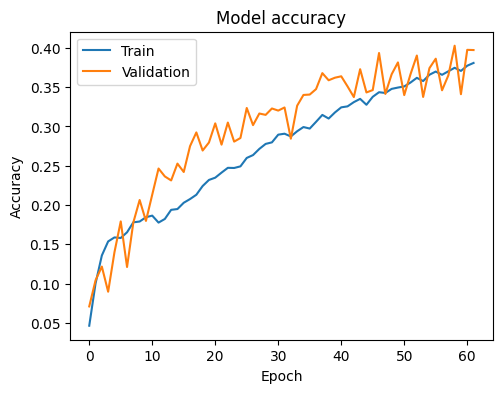

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

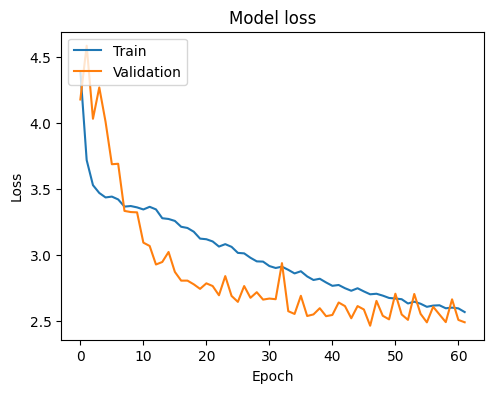

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset, steps=7)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3920 - loss: 2.5731
Test Loss: 2.5511417388916016
Test Accuracy: 0.4094264507293701


In [ ]:
img=tf.io.read_file('/content/large_dataset/test/Akarna_Dhanurasana/Akarna_Dhanurasana_image_76.jpg')
img=tf.image.decode_jpeg(img, channels=3)
results=pose.process(img.numpy())

In [ ]:
features=[[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark]
joint_angles = extract_joint_angles(features)
flattened_keypoints = np.array(features).flatten()
features_vector = np.concatenate([flattened_keypoints, joint_angles], axis=0)
ypred=model.predict(np.array([features_vector])).argmax(axis=1)
print('Pose Predicted:', label_lookup.get_vocabulary()[ypred[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Pose Predicted: Akarna_Dhanurasana


In [ ]:
label_lookup.save_assets('label_lookup_')